# Method 9 - Best Fresh Ideas DGTW Timing

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Novus HFU

novus_hfu = hfu.get_novus_hfu()

# Get HFU Data

%store -r inst_data

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Returns for Fresh Ideas

%store -r r

# Get Adjusted Quantities

qty_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='quantity',
                           aggfunc='sum')
qty_pivot = qty_pivot.mul(r.splits.reindex(qty_pivot.index), level=1).fillna(0)
qty_pivot = qty_pivot - qty_pivot.shift(1)
flat_qty = pd.melt(qty_pivot.reset_index(), id_vars='datadate', value_name='qty_change')
flat_qty = flat_qty[flat_qty['qty_change'] > 0]

# Get Pos Size Change

pos_size_pivot = pd.pivot_table(inst_data, index='datadate', columns=['institution_id', 'fsym_id'], values='target',
                                aggfunc='sum')
pos_size_pivot = pos_size_pivot - pos_size_pivot.shift(1)
flat_pos_size = pd.melt(pos_size_pivot.reset_index(), id_vars='datadate', value_name='size_change')
flat_pos_size = flat_pos_size[flat_pos_size['size_change'] > 0]

# Calc HFU Asset Weight

valid_data['weight'] = valid_data.groupby(['datadate', 'fsym_id'])['pos_val'].transform('sum') / \
                                          valid_data.groupby('datadate')['pos_val'].transform('sum')

# Calculate HFU Relative Weight

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Fresh Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

# Get Best
    
best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Filter to Fresh

best_ideas = best_ideas.merge(flat_qty).merge(flat_pos_size)

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')[
    'institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_beg_pos = p.beg_port.iloc[1:].resample('M', level=0).apply(epd.take_first)
dgtw = crsp.get_dgtw_returns(list(set(best_ideas['fsym_id'].dropna())),
                    best_ideas['datadate'].min(), pd.datetime(2018, 12, 31))
dgtw_pivot = pd.pivot_table(dgtw, index='datadate', columns='fsym_id', values='total_return')
dgtw_cont = monthly_beg_pos.mul(dgtw_pivot, axis=1, level=0).sum(axis=1)
dgtw_cont = dgtw_cont[dgtw_cont != 0]

rf = bi.get_risk_free_rate()
monthly_return = dgtw_cont.loc['1999-07-01':]
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

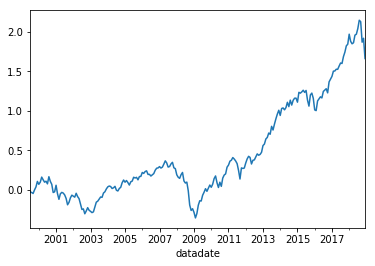

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.108163
2000-12-31   -0.118648
2001-12-31   -0.043230
2002-12-31   -0.204508
2003-12-31    0.363191
2004-12-31    0.111285
2005-12-31    0.040714
2006-12-31    0.091411
2007-12-31   -0.007013
2008-12-31   -0.399228
2009-12-31    0.392829
2010-12-31    0.212646
2011-12-31   -0.008831
2012-12-31    0.155975
2013-12-31    0.359936
2014-12-31    0.076228
2015-12-31   -0.000472
2016-12-31    0.111004
2017-12-31    0.184902
2018-12-31   -0.063927
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1625.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          8.88e-167
Time:                        21:12:29   Log-Likelihood:                 794.65
No. Observations:                 234   AIC:                            -1579.
Df Residuals:                     229   BIC:                            -1562.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.145      0.033    9.73e-05       0.002
mktrf          0.9541      0.015     62.412      0.000       0.924       0.984
me             0.0720      0.018      4.047      0.000       0.037       0.107
ia             0.0308      0.027      1.141      0.255      -0.022       0.084
roe           -0.0505      0.023     -2.182      0.030      -0.096      -0.005
==============================================================================
Omnibus:                       74.395   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.877
Skew:                           0.816   Prob(JB):                    4.48e-208
Kurtosis:                      12.761   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     2301.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.46e-183
Time:                        21:12:29   Log-Likelihood:                 794.65
No. Observations:                 234   AIC:                            -1579.
Df Residuals:                     229   BIC:                            -1562.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.865      0.062   -6.08e-05       0.002
mktrf          0.9541      0.020     47.802      0.000       0.915       0.993
me             0.0720      0.056      1.279      0.201      -0.038       0.182
ia             0.0308      0.058      0.529      0.597      -0.083       0.145
roe           -0.0505      0.048     -1.049      0.294      -0.145       0.044
==============================================================================
Omnibus:                       74.395   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.877
Skew:                           0.816   Prob(JB):                    4.48e-208
Kurtosis:                      12.761   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     2497.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.52e-187
Time:                        21:12:29   Log-Likelihood:                 794.65
No. Observations:                 234   AIC:                            -1579.
Df Residuals:                     229   BIC:                            -1562.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.799      0.072      -0.000       0.003
mktrf          0.9541      0.016     60.813      0.000       0.923       0.985
me             0.0720      0.061      1.177      0.239      -0.048       0.192
ia             0.0308      0.048      0.641      0.522      -0.063       0.125
roe           -0.0505      0.043     -1.179      0.238      -0.134       0.033
==============================================================================
Omnibus:                       74.395   Durbin-Watson:                   1.946
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              954.877
Skew:                           0.816   Prob(JB):                    4.48e-208
Kurtosis:                      12.761   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1255.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.10e-163
Time:                        21:12:29   Log-Likelihood:                 791.19
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     228   BIC:                            -1550.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.314      0.190      -0.000       0.002
mktrf          0.9654      0.016     61.967      0.000       0.935       0.996
smb            0.1270      0.021      6.180      0.000       0.087       0.168
hml            0.0839      0.024      3.461      0.001       0.036       0.132
rmw            0.0202      0.027      0.738      0.461      -0.034       0.074
cma           -0.0965      0.035     -2.770      0.006      -0.165      -0.028
==============================================================================
Omnibus:                       80.775   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              868.742
Skew:                           0.997   Prob(JB):                    2.26e-189
Kurtosis:                      12.226   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1279.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.46e-164
Time:                        21:12:29   Log-Likelihood:                 791.19
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     228   BIC:                            -1550.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.209      0.227      -0.000       0.002
mktrf          0.9654      0.018     53.456      0.000       0.930       1.001
smb            0.1270      0.047      2.715      0.007       0.035       0.219
hml            0.0839      0.048      1.735      0.083      -0.011       0.179
rmw            0.0202      0.028      0.724      0.469      -0.035       0.075
cma           -0.0965      0.057     -1.689      0.091      -0.208       0.015
==============================================================================
Omnibus:                       80.775   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              868.742
Skew:                           0.997   Prob(JB):                    2.26e-189
Kurtosis:                      12.226   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.965
Model:                            OLS   Adj. R-squared:                  0.964
Method:                 Least Squares   F-statistic:                     1678.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.33e-177
Time:                        21:12:29   Log-Likelihood:                 791.19
No. Observations:                 234   AIC:                            -1570.
Df Residuals:                     228   BIC:                            -1550.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      1.131      0.258      -0.001       0.002
mktrf          0.9654      0.019     50.915      0.000       0.928       1.003
smb            0.1270      0.047      2.724      0.006       0.036       0.218
hml            0.0839      0.045      1.882      0.060      -0.003       0.171
rmw            0.0202      0.026      0.785      0.432      -0.030       0.071
cma           -0.0965      0.048     -2.003      0.045      -0.191      -0.002
==============================================================================
Omnibus:                       80.775   Durbin-Watson:                   1.859
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              868.742
Skew:                           0.997   Prob(JB):                    2.26e-189
Kurtosis:                      12.226   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1815.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.26e-172
Time:                        21:12:29   Log-Likelihood:                 807.16
No. Observations:                 234   AIC:                            -1604.
Df Residuals:                     229   BIC:                            -1587.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      2.266      0.024       0.000       0.002
mktrf          0.9341      0.013     70.018      0.000       0.908       0.960
smb            0.1271      0.017      7.633      0.000       0.094       0.160
hml            0.0530      0.017      3.206      0.002       0.020       0.086
umd           -0.0767      0.011     -7.065      0.000      -0.098      -0.055
==============================================================================
Omnibus:                       30.403   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.512
Skew:                           0.116   Prob(JB):                     2.33e-40
Kurtosis:                       7.320   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1672.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.80e-168
Time:                        21:12:29   Log-Likelihood:                 807.16
No. Observations:                 234   AIC:                            -1604.
Df Residuals:                     229   BIC:                            -1587.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.849      0.065   -7.06e-05       0.002
mktrf          0.9341      0.017     55.556      0.000       0.901       0.967
smb            0.1271      0.041      3.122      0.002       0.047       0.207
hml            0.0530      0.028      1.920      0.055      -0.001       0.107
umd           -0.0767      0.027     -2.870      0.004      -0.129      -0.024
==============================================================================
Omnibus:                       30.403   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.512
Skew:                           0.116   Prob(JB):                     2.33e-40
Kurtosis:                       7.320   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1679.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.41e-168
Time:                        21:12:29   Log-Likelihood:                 807.16
No. Observations:                 234   AIC:                            -1604.
Df Residuals:                     229   BIC:                            -1587.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.719      0.086      -0.000       0.003
mktrf          0.9341      0.017     55.385      0.000       0.901       0.967
smb            0.1271      0.038      3.331      0.001       0.052       0.202
hml            0.0530      0.026      2.066      0.039       0.003       0.103
umd           -0.0767      0.027     -2.848      0.004      -0.129      -0.024
==============================================================================
Omnibus:                       30.403   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              182.512
Skew:                           0.116   Prob(JB):                     2.33e-40
Kurtosis:                       7.320   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     638.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.75e-77
Time:                        21:12:29   Log-Likelihood:                 380.95
No. Observations:                 120   AIC:                            -751.9
Df Residuals:                     115   BIC:                            -738.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.816      0.072      -0.000       0.004
mktrf          0.9389      0.027     35.246      0.000       0.886       0.992
me             0.0222      0.026      0.844      0.401      -0.030       0.074
ia             0.0242      0.041      0.587      0.558      -0.057       0.106
roe           -0.0707      0.036     -1.938      0.055      -0.143       0.002
==============================================================================
Omnibus:                       35.487   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.530
Skew:                           0.854   Prob(JB):                     4.18e-37
Kurtosis:                       8.530   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1032.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.55e-89
Time:                        21:12:29   Log-Likelihood:                 380.95
No. Observations:                 120   AIC:                            -751.9
Df Residuals:                     115   BIC:                            -738.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.508      0.132      -0.001       0.004
mktrf          0.9389      0.028     33.071      0.000       0.883       0.995
me             0.0222      0.061      0.366      0.715      -0.097       0.141
ia             0.0242      0.070      0.345      0.730      -0.113       0.162
roe           -0.0707      0.062     -1.146      0.252      -0.191       0.050
==============================================================================
Omnibus:                       35.487   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.530
Skew:                           0.854   Prob(JB):                     4.18e-37
Kurtosis:                       8.530   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     1313.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           6.24e-95
Time:                        21:12:29   Log-Likelihood:                 380.95
No. Observations:                 120   AIC:                            -751.9
Df Residuals:                     115   BIC:                            -738.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      1.347      0.178      -0.001       0.004
mktrf          0.9389      0.021     44.491      0.000       0.898       0.980
me             0.0222      0.067      0.332      0.740      -0.109       0.153
ia             0.0242      0.059      0.409      0.682      -0.092       0.140
roe           -0.0707      0.054     -1.311      0.190      -0.176       0.035
==============================================================================
Omnibus:                       35.487   Durbin-Watson:                   1.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              167.530
Skew:                           0.854   Prob(JB):                     4.18e-37
Kurtosis:                       8.530   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     448.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.46e-73
Time:                        21:12:29   Log-Likelihood:                 373.99
No. Observations:                 120   AIC:                            -736.0
Df Residuals:                     114   BIC:                            -719.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.429      0.156      -0.001       0.004
mktrf          0.9886      0.030     33.070      0.000       0.929       1.048
smb            0.1027      0.034      3.032      0.003       0.036       0.170
hml            0.0549      0.041      1.323      0.189      -0.027       0.137
rmw            0.0526      0.049      1.076      0.284      -0.044       0.150
cma           -0.0882      0.054     -1.645      0.103      -0.194       0.018
==============================================================================
Omnibus:                       32.535   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.689
Skew:                           0.820   Prob(JB):                     2.54e-29
Kurtosis:                       7.863   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     573.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.16e-79
Time:                        21:12:29   Log-Likelihood:                 373.99
No. Observations:                 120   AIC:                            -736.0
Df Residuals:                     114   BIC:                            -719.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.350      0.177      -0.001       0.004
mktrf          0.9886      0.039     25.105      0.000       0.911       1.066
smb            0.1027      0.065      1.570      0.117      -0.026       0.231
hml            0.0549      0.072      0.767      0.443      -0.085       0.195
rmw            0.0526      0.063      0.837      0.402      -0.071       0.176
cma           -0.0882      0.078     -1.124      0.261      -0.242       0.066
==============================================================================
Omnibus:                       32.535   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.689
Skew:                           0.820   Prob(JB):                     2.54e-29
Kurtosis:                       7.863   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.952
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     823.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.10e-87
Time:                        21:12:29   Log-Likelihood:                 373.99
No. Observations:                 120   AIC:                            -736.0
Df Residuals:                     114   BIC:                            -719.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.001      1.219      0.223      -0.001       0.004
mktrf          0.9886      0.043     22.895      0.000       0.904       1.073
smb            0.1027      0.065      1.590      0.112      -0.024       0.229
hml            0.0549      0.069      0.799      0.424      -0.080       0.189
rmw            0.0526      0.067      0.782      0.434      -0.079       0.185
cma           -0.0882      0.066     -1.340      0.180      -0.217       0.041
==============================================================================
Omnibus:                       32.535   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.689
Skew:                           0.820   Prob(JB):                     2.54e-29
Kurtosis:                       7.863   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     692.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.98e-79
Time:                        21:12:29   Log-Likelihood:                 385.63
No. Observations:                 120   AIC:                            -761.3
Df Residuals:                     115   BIC:                            -747.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.211      0.029       0.000       0.004
mktrf          0.9248      0.023     40.974      0.000       0.880       0.969
smb            0.1028      0.026      4.002      0.000       0.052       0.154
hml            0.0415      0.026      1.613      0.109      -0.009       0.093
umd           -0.0901      0.016     -5.680      0.000      -0.122      -0.059
==============================================================================
Omnibus:                        6.845   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.033   Jarque-Bera (JB):               11.444
Skew:                          -0.125   Prob(JB):                      0.00327
Kurtosis:                       4.492   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     825.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.18e-83
Time:                        21:12:29   Log-Likelihood:                 385.63
No. Observations:                 120   AIC:                            -761.3
Df Residuals:                     115   BIC:                            -747.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      2.077      0.038       0.000       0.004
mktrf          0.9248      0.027     34.881      0.000       0.873       0.977
smb            0.1028      0.044      2.350      0.019       0.017       0.189
hml            0.0415      0.031      1.338      0.181      -0.019       0.102
umd           -0.0901      0.029     -3.096      0.002      -0.147      -0.033
==============================================================================
Omnibus:                        6.845   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.033   Jarque-Bera (JB):               11.444
Skew:                          -0.125   Prob(JB):                      0.00327
Kurtosis:                       4.492   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     957.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.01e-87
Time:                        21:12:29   Log-Likelihood:                 385.63
No. Observations:                 120   AIC:                            -761.3
Df Residuals:                     115   BIC:                            -747.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0021      0.001      1.920      0.055   -4.27e-05       0.004
mktrf          0.9248      0.027     33.760      0.000       0.871       0.978
smb            0.1028      0.041      2.534      0.011       0.023       0.182
hml            0.0415      0.030      1.362      0.173      -0.018       0.101
umd           -0.0901      0.029     -3.162      0.002      -0.146      -0.034
==============================================================================
Omnibus:                        6.845   Durbin-Watson:                   1.848
Prob(Omnibus):                  0.033   Jarque-Bera (JB):               11.444
Skew:                          -0.125   Prob(JB):                      0.00327
Kurtosis:                       4.492   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     2709.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.40e-108
Time:                        21:12:29   Log-Likelihood:                 475.20
No. Observations:                 114   AIC:                            -940.4
Df Residuals:                     109   BIC:                            -926.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.847      0.005       0.000       0.002
mktrf          0.9386      0.011     83.360      0.000       0.916       0.961
me             0.2117      0.017     12.176      0.000       0.177       0.246
ia             0.0140      0.024      0.583      0.561      -0.034       0.062
roe           -0.0393      0.021     -1.854      0.066      -0.081       0.003
==============================================================================
Omnibus:                        0.957   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.622
Skew:                          -0.168   Prob(JB):                        0.733
Kurtosis:                       3.135   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     3673.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.16e-115
Time:                        21:12:29   Log-Likelihood:                 475.20
No. Observations:                 114   AIC:                            -940.4
Df Residuals:                     109   BIC:                            -926.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.670      0.008       0.000       0.002
mktrf          0.9386      0.012     78.058      0.000       0.915       0.962
me             0.2117      0.019     10.971      0.000       0.174       0.249
ia             0.0140      0.031      0.455      0.649      -0.046       0.075
roe           -0.0393      0.015     -2.637      0.008      -0.068      -0.010
==============================================================================
Omnibus:                        0.957   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.622
Skew:                          -0.168   Prob(JB):                        0.733
Kurtosis:                       3.135   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     5798.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.76e-126
Time:                        21:12:29   Log-Likelihood:                 475.20
No. Observations:                 114   AIC:                            -940.4
Df Residuals:                     109   BIC:                            -926.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.000      2.975      0.003       0.000       0.002
mktrf          0.9386      0.011     84.327      0.000       0.917       0.960
me             0.2117      0.018     11.751      0.000       0.176       0.247
ia             0.0140      0.031      0.453      0.651      -0.047       0.075
roe           -0.0393      0.012     -3.242      0.001      -0.063      -0.016
==============================================================================
Omnibus:                        0.957   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.620   Jarque-Bera (JB):                0.622
Skew:                          -0.168   Prob(JB):                        0.733
Kurtosis:                       3.135   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     3074.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.11e-114
Time:                        21:12:29   Log-Likelihood:                 495.49
No. Observations:                 114   AIC:                            -979.0
Df Residuals:                     108   BIC:                            -962.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.186      0.238      -0.000       0.001
mktrf          0.9356      0.009    103.618      0.000       0.918       0.954
smb            0.1894      0.015     12.918      0.000       0.160       0.218
hml            0.0601      0.019      3.213      0.002       0.023       0.097
rmw           -0.0700      0.023     -3.057      0.003      -0.115      -0.025
cma           -0.0503      0.029     -1.730      0.086      -0.108       0.007
==============================================================================
Omnibus:                        1.360   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.878
Skew:                           0.080   Prob(JB):                        0.645
Kurtosis:                       3.399   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1739.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.91e-101
Time:                        21:12:29   Log-Likelihood:                 495.49
No. Observations:                 114   AIC:                            -979.0
Df Residuals:                     108   BIC:                            -962.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.879      0.379      -0.000       0.001
mktrf          0.9356      0.012     80.791      0.000       0.913       0.958
smb            0.1894      0.015     12.776      0.000       0.160       0.218
hml            0.0601      0.015      3.904      0.000       0.030       0.090
rmw           -0.0700      0.023     -3.024      0.002      -0.115      -0.025
cma           -0.0503      0.026     -1.958      0.050      -0.101    5.15e-05
==============================================================================
Omnibus:                        1.360   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.878
Skew:                           0.080   Prob(JB):                        0.645
Kurtosis:                       3.399   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     2391.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.83e-109
Time:                        21:12:29   Log-Likelihood:                 495.49
No. Observations:                 114   AIC:                            -979.0
Df Residuals:                     108   BIC:                            -962.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      0.785      0.432      -0.001       0.001
mktrf          0.9356      0.011     85.795      0.000       0.914       0.957
smb            0.1894      0.015     12.961      0.000       0.161       0.218
hml            0.0601      0.012      4.855      0.000       0.036       0.084
rmw           -0.0700      0.021     -3.263      0.001      -0.112      -0.028
cma           -0.0503      0.023     -2.234      0.026      -0.094      -0.006
==============================================================================
Omnibus:                        1.360   Durbin-Watson:                   1.824
Prob(Omnibus):                  0.507   Jarque-Bera (JB):                0.878
Skew:                           0.080   Prob(JB):                        0.645
Kurtosis:                       3.399   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     3444.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.03e-113
Time:                        21:12:29   Log-Likelihood:                 488.77
No. Observations:                 114   AIC:                            -967.5
Df Residuals:                     109   BIC:                            -953.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.550      0.583      -0.000       0.001
mktrf          0.9419      0.009     99.428      0.000       0.923       0.961
smb            0.2066      0.015     13.986      0.000       0.177       0.236
hml            0.0624      0.015      4.099      0.000       0.032       0.093
umd           -0.0079      0.011     -0.688      0.493      -0.031       0.015
==============================================================================
Omnibus:                        2.211   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.809
Skew:                           0.113   Prob(JB):                        0.405
Kurtosis:                       3.575   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     1700.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.42e-97
Time:                        21:12:29   Log-Likelihood:                 488.77
No. Observations:                 114   AIC:                            -967.5
Df Residuals:                     109   BIC:                            -953.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.000      0.390      0.697      -0.001       0.001
mktrf          0.9419      0.013     74.603      0.000       0.917       0.967
smb            0.2066      0.015     14.201      0.000       0.178       0.235
hml            0.0624      0.014      4.381      0.000       0.034       0.090
umd           -0.0079      0.014     -0.579      0.562      -0.035       0.019
==============================================================================
Omnibus:                        2.211   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.809
Skew:                           0.113   Prob(JB):                        0.405
Kurtosis:                       3.575   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     2259.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.83e-104
Time:                        21:12:29   Log-Likelihood:                 488.77
No. Observations:                 114   AIC:                            -967.5
Df Residuals:                     109   BIC:                            -953.8
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.362      0.717      -0.001       0.001
mktrf          0.9419      0.012     78.701      0.000       0.918       0.965
smb            0.2066      0.014     15.220      0.000       0.180       0.233
hml            0.0624      0.012      5.071      0.000       0.038       0.086
umd           -0.0079      0.014     -0.554      0.579      -0.036       0.020
==============================================================================
Omnibus:                        2.211   Durbin-Watson:                   1.740
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                1.809
Skew:                           0.113   Prob(JB):                        0.405
Kurtosis:                       3.575   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""